In [6]:
import torch
from yolact import Yolact
from skimage.io import imread

In [195]:
net = Yolact()
model_name = "yolact_darknet53_54_800000.pth"
net.load_weights(model_name)
net.eval()
print(' Done.')

 Done.


In [196]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [197]:
from layers.output_utils import postprocess, undo_image_transformation
from mask_rcnn.mask_rcnn import MaskRCNNDetector
from data.config import set_cfg,cfg

In [306]:
image_path = "/media/pave/HD2/datasets/Kitti/object/training/image_2/"  + format(571,"06d") + ".png"
im = plt.imread(image_path)
display_image = imread(image_path)
finim = np.moveaxis(im, 2, 0)

In [307]:
im = torch.Tensor(im)
h,w,c = im.shape

In [308]:
sys.path.append("/home/pave/vision_ws/LDLS/")

In [309]:
config = "yolact_darknet53_config"
set_cfg(config)

In [310]:
import sys
from lidar_segmentation.detections import MaskRCNNDetections

In [311]:
cfg.mask_proto_debug = False

NameError: name 'pred' is not defined

In [343]:
from data import COCODetection, get_label_map, MEANS, COLORS
from collections import defaultdict
from utils.augmentations import FastBaseTransform

display_lincomb = False
crop = True
score_threshold = 0.15
top_k = 15
display_masks = True
display_fps = False
display_bboxes = True
display_text = True
display_scores = True
from utils import timer
def prep_display(dets_out, img, h, w, undo_transform=True, class_color=False, mask_alpha=0.45, fps_str=''):
    """
    Note: If undo_transform=False then im_h and im_w are allowed to be None.
    """
    color_cache = defaultdict(lambda: {})

    if undo_transform:
        img_numpy = undo_image_transformation(img, w, h)
        img_gpu = torch.Tensor(img_numpy).cuda()
    else:
        img_gpu = img / 255.0
        h, w, _ = img.shape
    
    with timer.env('Postprocess'):
        save = cfg.rescore_bbox
        cfg.rescore_bbox = True
        t = postprocess(dets_out, w, h, visualize_lincomb = display_lincomb,
                                        crop_masks        = crop,
                                        score_threshold   = score_threshold)
        cfg.rescore_bbox = save
    
    with timer.env('Copy'):
        idx = t[1].argsort(0, descending=True)[:top_k]
        
        if cfg.eval_mask_branch:
            # Masks are drawn on the GPU, so don't copy
            masks = t[3][idx]
        classes, scores, boxes = [x[idx].cpu().numpy() for x in t[:3]]

    num_dets_to_consider = min(top_k, classes.shape[0])
    for j in range(num_dets_to_consider):
        if scores[j] < score_threshold:
            num_dets_to_consider = j
            break

    # Quick and dirty lambda for selecting the color for a particular index
    # Also keeps track of a per-gpu color cache for maximum speed
    def get_color(j, on_gpu=None):
        global color_cache
        color_cache = defaultdict(lambda: {})

        color_idx = (classes[j] * 5 if class_color else j * 5) % len(COLORS)
        if on_gpu is not None and color_idx in color_cache[on_gpu]:
            return color_cache[on_gpu][color_idx]
        else:
            color = COLORS[color_idx]
            if not undo_transform:
                # The image might come in as RGB or BRG, depending
                color = (color[2], color[1], color[0])
            if on_gpu is not None:
                color = torch.Tensor(color).to(on_gpu).float() / 255.
                color_cache[on_gpu][color_idx] = color
            return color

    # First, draw the masks on the GPU where we can do it really fast
    # Beware: very fast but possibly unintelligible mask-drawing code ahead
    # I wish I had access to OpenGL or Vulkan but alas, I guess Pytorch tensor operations will have to suffice
    if display_masks and cfg.eval_mask_branch and num_dets_to_consider > 0:
        # After this, mask is of size [num_dets, h, w, 1]
        masks = masks[:num_dets_to_consider, :, :, None]
        
        # Prepare the RGB images for each mask given their color (size [num_dets, h, w, 1])
        colors = torch.cat([get_color(j, on_gpu=img_gpu.device.index).view(1, 1, 1, 3) for j in range(num_dets_to_consider)], dim=0)
        
        masks_color = masks.repeat(1, 1, 1, 3) * colors.cpu() * mask_alpha

        # This is 1 everywhere except for 1-mask_alpha where the mask is
        inv_alph_masks = masks * (-mask_alpha) + 1
        
        # I did the math for this on pen and paper. This whole block should be equivalent to:
        #    for j in range(num_dets_to_consider):
        #        img_gpu = img_gpu * inv_alph_masks[j] + masks_color[j]
        masks_color_summand = masks_color[0]
        if num_dets_to_consider > 1:
            inv_alph_cumul = inv_alph_masks[:(num_dets_to_consider-1)].cumprod(dim=0)
            masks_color_cumul = masks_color[1:] * inv_alph_cumul
            masks_color_summand += masks_color_cumul.sum(dim=0)

        img_gpu = img_gpu.cpu() * inv_alph_masks.cpu().prod(dim=0) + masks_color_summand.cpu()
    
    if display_fps:
            # Draw the box for the fps on the GPU
        font_face = cv2.FONT_HERSHEY_DUPLEX
        font_scale = 0.6
        font_thickness = 1

        text_w, text_h = cv2.getTextSize(fps_str, font_face, font_scale, font_thickness)[0]

        img_gpu[0:text_h+8, 0:text_w+8] *= 0.6 # 1 - Box alpha


    # Then draw the stuff that needs to be done on the cpu
    # Note, make sure this is a uint8 tensor or opencv will not anti alias text for whatever reason
    img_numpy = (img_gpu * 255).byte().cpu().numpy()

    if  display_fps:
        # Draw the text on the CPU
        text_pt = (4, text_h + 2)
        text_color = [255, 255, 255]

        cv2.putText(img_numpy, fps_str, text_pt, font_face, font_scale, text_color, font_thickness, cv2.LINE_AA)
    
    if num_dets_to_consider == 0:
        return img_numpy

    if display_text or display_bboxes:
        for j in reversed(range(num_dets_to_consider)):
            x1, y1, x2, y2 = boxes[j, :]
            color = get_color(j)
            score = scores[j]

            if display_bboxes:
                cv2.rectangle(img_numpy, (x1, y1), (x2, y2), color, 1)

            if display_text:
                _class = cfg.dataset.class_names[classes[j]]
                text_str = '%s: %.2f' % (_class, score) if display_scores else _class

                font_face = cv2.FONT_HERSHEY_DUPLEX
                font_scale = 0.6
                font_thickness = 1

                text_w, text_h = cv2.getTextSize(text_str, font_face, font_scale, font_thickness)[0]

                text_pt = (x1, y1 - 3)
                text_color = [255, 255, 255]

                cv2.rectangle(img_numpy, (x1, y1), (x1 + text_w, y1 - text_h - 4), color, -1)
                cv2.putText(img_numpy, text_str, text_pt, font_face, font_scale, text_color, font_thickness, cv2.LINE_AA)
            
    
    return img_numpy
with torch.no_grad():
    frame = torch.from_numpy(cv2.imread(image_path)).float()
    batch = FastBaseTransform()(frame.unsqueeze(0))
    print(batch.shape)
    preds = net(batch)
    with torch.no_grad():
        classes, scores, boxes, masks = postprocess(preds,w,h,crop_masks=True,score_threshold=0.15)

    #res = prep_display(net(torch.Tensor(finim).unsqueeze(0)),torch.Tensor(display_image),h,w)

torch.Size([1, 3, 550, 550])


In [344]:
# with torch.no_grad():
#     classes, scores, boxes, masks = postprocess(net(torch.Tensor(finim).unsqueeze(0)),w,h,crop_masks=True,score_threshold=0.15)

new_box = []
for idx,box in enumerate(boxes):
    x1,y1,x2,y2 = box.numpy()
    new_box.append(np.array([y1,x1,y2,x2]))

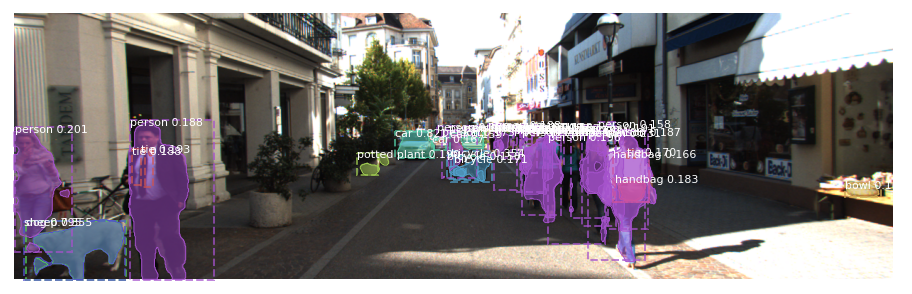

In [345]:
result = {}
result['rois'] = np.array(new_box)
result['masks'] = np.moveaxis(masks.numpy(),0,2)
result['class_ids'] = classes.numpy() + 1
result['scores'] = scores.numpy()
all_results = [result]
all_images = [im]
all_detections = [MaskRCNNDetections(shape=im.shape,
                                             rois=result['rois'],
                                             masks=result['masks'],
                                             class_ids=result['class_ids'],
                                             scores=result['scores'])
                          for image,result in zip(all_images, all_results)]
all_detections[0].visualize(display_image)

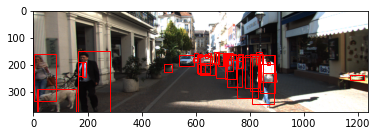

In [346]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
for box in boxes:
    x1,y1,x2,y2 = box.numpy()
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

plt.show()

tensor([[ 967,  223, 1060,  255],
        [ 354,  219,  445,  259],
        [ 317,  225,  392,  271],
        [ 297,  226,  475,  284],
        [ 230,  232,  329,  271],
        [ 457,  182,  595,  244],
        [ 857,  230,  951,  269],
        [ 270,  227,  351,  271],
        [ 225,  219,  360,  268],
        [ 240,  233,  358,  283],
        [ 284,  214,  387,  267],
        [ 881,  227,  994,  269],
        [1075,  257, 1224,  340],
        [ 901,  234, 1034,  278],
        [ 815,  234,  950,  282],
        [ 817,  216,  953,  267],
        [ 910,  217, 1036,  264],
        [ 314,  213,  462,  266],
        [ 646,  179,  843,  291]])

In [347]:
detector = MaskRCNNDetector()




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


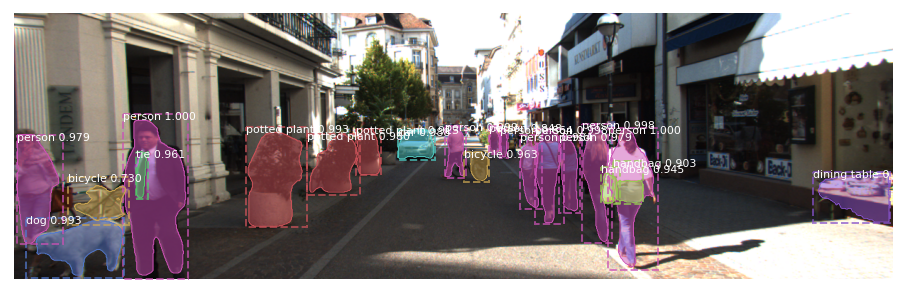

In [350]:

detector.detect(display_image).visualize(display_image)

In [ ]:
masks.shape

In [ ]:
boxes